In [1]:

import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR

import timm

In [2]:
import os
os.chdir('/home/cpssadv/JXY/galaxy_decals10')

In [3]:
with h5py.File('./Galaxy10_DECals.h5', 'r') as f:
  images = np.array(f['images'])
  labels = np.array(f['ans'])

Opening and GaussianBlur

In [4]:
k = np.ones((6, 6), np.uint8)
for i in range(len(images)):
    images[i] = cv2.morphologyEx(images[i], cv2.MORPH_OPEN, kernel=k)
    images[i] = cv2.GaussianBlur(images[i],(7, 7),0,0)

Class weights

In [5]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels.reshape(-1))

Augmentation

In [6]:
train_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(45),
    T.CenterCrop(224),
    T.ColorJitter(0,0.2),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])
infer_transforms = T.Compose([
    T.ToTensor(),
    T.CenterCrop(224),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

In [7]:
def one_hot(labels,Label_class):
    one_hot_label = np.array([[int(i == int(labels[j])) for i in range(Label_class)] for j in range(len(labels))])
    return one_hot_label
labels = one_hot(labels, 10)

In [8]:
train_x, val_x, train_y, val_y = train_test_split(images, labels, test_size=0.15, stratify=labels)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.15, stratify=train_y)

In [9]:
class GalaxyDataset(Dataset):
  def __init__(self, datas, labels, transforms=None):
    super(GalaxyDataset, self).__init__()
    self.datas = datas
    self.labels = labels
    self.transforms = transforms

  def __getitem__(self, index):
    label = torch.tensor(self.labels[index].astype('float32'))
    image = self.datas[index]
    if self.transforms is not None:
      image = self.transforms(image)
    return image, label

  def __len__(self):
    return len(self.datas)

In [10]:
train_dataset = GalaxyDataset(train_x, train_y, train_transforms)
val_dataset = GalaxyDataset(val_x, val_y, infer_transforms)
test_dataset = GalaxyDataset(test_x, test_y, infer_transforms)

hyperparams

In [11]:
num_classes=10
batch_size=32
device= 'cuda' if torch.cuda.is_available() else 'cpu'
accs=[]
epochs=50
lr=0.0001

In [12]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=1
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=1
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=1
)

In [17]:
model = timm.create_model('densenet201',pretrained=False,num_classes=num_classes)
model.load_state_dict(torch.load('models/dense_201.pth'))
model = model.to(device)
criterion = nn.CrossEntropyLoss(torch.tensor(class_weights).to(device),reduction='mean',label_smoothing=0.05)
optimizer = torch.optim.Adam(model.parameters(), lr =lr)
scheduler = CosineAnnealingLR(optimizer, T_max=32, eta_min=1e-5)

In [14]:
for epoch in range(epochs):
    all_loss = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels) / batch_size
        all_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        each = np.zeros([num_classes])
        for images, labels in test_loader:
            images = images.to(device)
            _, labels = torch.max(labels, 1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            predicted = predicted.cpu()
            for i in range(labels.size(0)):
                if labels[i] == predicted[i]:
                    correct += 1
                    each[labels[i]] += 1
        print('Epoch [{}/{}],  Loss: {:.4f},test acc: {:.2f} %'.format(epoch + 1, epochs, all_loss,
                                                                       100 * correct / total))
        accs.append(correct / total)

KeyboardInterrupt: 

In [ ]:
plt.plot(accs)
plt.ylabel("acc")
plt.xlabel("epochs")
plt.show()

In [18]:
with torch.no_grad():
    pred_all=[]
    label_all=[]
    for images, labels in val_loader:
        images = images.type(torch.FloatTensor).to(device)
        outputs = model(images)
        _, labels = torch.max(labels, 1)
        _, predicted = torch.max(outputs.data, 1)
        label_all+=list(labels)
        pred_all+= list(predicted.cpu())
    pred_all=np.array(pred_all)

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       162
           1       0.97      0.95      0.96       278
           2       0.99      0.94      0.96       397
           3       0.96      0.99      0.98       304
           4       0.93      1.00      0.96        50
           5       0.95      0.95      0.95       307
           6       0.91      0.94      0.92       274
           7       0.92      0.90      0.91       394
           8       0.96      0.97      0.97       214
           9       0.99      0.98      0.98       281

    accuracy                           0.94      2661
   macro avg       0.94      0.95      0.94      2661
weighted avg       0.95      0.94      0.95      2661



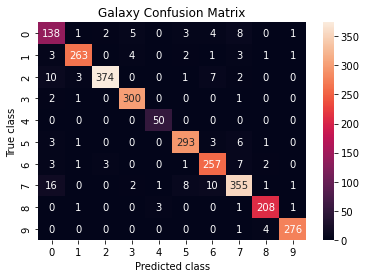

In [19]:
torch.save(model.state_dict(),f'models/dense_201_{accuracy_score(label_all,pred_all):.2f}.pth')
print(classification_report(label_all,pred_all))
matrix = confusion_matrix(label_all, pred_all)
sns.heatmap(matrix, annot=True, fmt='.0f')
plt.title('Galaxy Confusion Matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

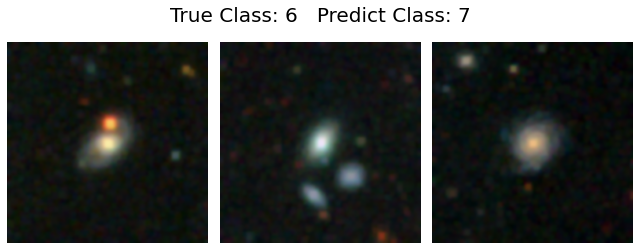

In [20]:
temp_true = np.array(label_all)
temp_pred = np.array(pred_all)
target_index = np.where((temp_true==6) * (temp_pred==7))[0]
fig, ax = plt.subplots(1, 3, figsize = (9,3.5))
counter = 0
for i in range(1):
    for j in range(3):
        if len(ax.shape)==1:
            ax[j].imshow(test_x[target_index[counter]])
            ax[j].axis('off')
        else:
            ax[i][j].imshow(test_x[target_index[counter]])
            ax[i][j].axis('off')
        counter += 1
tittle = 'True Class: ' + str(6) + '   Predict Class: ' + str(7)
fig.suptitle(tittle, fontsize=20)
plt.tight_layout()
plt.show()

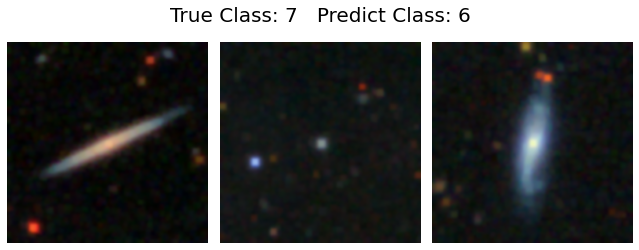

In [21]:
temp_true = np.array(label_all)
temp_pred = np.array(pred_all)
target_index = np.where((temp_true==7) * (temp_pred==6))[0]
fig, ax = plt.subplots(1, 3, figsize = (9,3.5))
counter = 0
for i in range(1):
    for j in range(3):
        if len(ax.shape)==1:
            ax[j].imshow(test_x[target_index[counter]])
            ax[j].axis('off')
        else:
            ax[i][j].imshow(test_x[target_index[counter]])
            ax[i][j].axis('off')
        counter += 1
tittle = 'True Class: ' + str(7) + '   Predict Class: ' + str(6)
fig.suptitle(tittle, fontsize=20)
plt.tight_layout()
plt.show()